In [105]:
import pandas as pd
import os
import pathlib

# This script needs xlrd!

def record_to_csv(file, filename, mode):
    """Convert Record sheets to csv file"""
    excel_file = pd.read_excel(file, sheet_name=None) # read the file
    df = pd.DataFrame() # create DataFrame to store data
    for name, sheet in excel_file.items(): 
        sheet['sheet'] = name # for each sheet append a column entitled with sheet label
        if "Record__" in f'{name}': # if it is a record sheet, append it to the main DataFrame
            header = sheet.iloc[0]
            sheet.columns = header
            sheet = sheet[1:]              
            df = pd.concat([df, sheet], ignore_index=True, sort=False)
        elif "Record" in f'{name}': # if it is a single record sheet, append it to the main DataFrame
            header = sheet.iloc[0]
            sheet.columns = header
            sheet = sheet[1:]              
            df = pd.concat([df, sheet], ignore_index=True, sort=False)
        elif "record" in f'{name}': 
            df = pd.concat([df, sheet], ignore_index=True, sort=False)
            df = df.rename(columns={'Voltage': 'Vol', 'Current': 'Cur', 'Capacity': 'Cap', 'Capacity Density': 'CmpCap'}) # would rather work further with the same format
        else:
            print("Skipping non-record sheet")
    df.reset_index(inplace=True, drop=True) # reset index so that it is cumulative throughout merged sheets
    if mode=="full":
        df.to_csv(os.path.join(pathlib.Path().absolute(),filename)+'_record_full'+'.csv', index=False, sep="\t") # save file
    if mode=="compact":
        df = df[['Cycle ID', 'Step ID', 'Time(H:M:S:ms)', 'RCap_Chg', 'RCap_DChg']]
        df.to_csv(os.path.join(pathlib.Path().absolute(),filename)+'_cycle_compact'+'.csv', index=False, sep="\t") # save file
    if mode=="ultracompact": 
        df = df[['CmpCap', 'Vol', 'Step ID']] # save only 'main' columns
        df.to_csv(os.path.join(pathlib.Path().absolute(),filename)+'_record_ultracompact'+'.csv', index=False, sep="\t") # save file

    
def cycle_to_csv(file, filename, mode):
    """Convert Cycle sheet to csv file"""
    if file[-1] == "x":
        df = pd.read_excel(file, sheet_name='Cycle') # read the sheet 'Cycle' in case of xlsx
        header = df.iloc[0]  # get header from first row
        df = df[1:] # remove first row 
        df.columns = header # set headers for columns
    elif file[-1] == "s":
        df = pd.read_excel(file, sheet_name='cycle') # read the sheet 'cycle' in case of xls
        df = df.rename(columns={'Specific Capacity-Chg': 'RCap_Chg', 'Specific Capacity-Dchg': 'RCap_DChg', 'Chg/DChg Efficiency': 'Efficiency'}) # would rather work further with the same format
    if mode=="full":
        df.to_csv(os.path.join(pathlib.Path().absolute(),filename)+'_cycle_full'+'.csv', index=False, sep="\t") # save file
    if mode=="compact":
        df = df[['Cycle ID', 'Cap_Chg', 'Cap_DChg', 'RCap_Chg', 'RCap_DChg']]
        df.to_csv(os.path.join(pathlib.Path().absolute(),filename)+'_cycle_compact'+'.csv', index=False, sep="\t") # save file
    if mode=="ultracompact":
        df = df[['Cycle ID', 'RCap_Chg', 'RCap_DChg']]
        df.to_csv(os.path.join(pathlib.Path().absolute(),filename)+'_cycle_ultracompact'+'.csv', index=False, sep="\t") # save file

def xlsx_to_csv(file, mode):
    """Convert xlsx of cycler data to text file"""
    filename, file_extension = os.path.splitext(file) 
    if file_extension == '.xlsx' or file_extension == '.xls': # extract data only from xlsx files
        cycle_to_csv(file, filename, mode)
        record_to_csv(file, filename, mode)
    else:
        print("Skipping non-xlsx file...")

def send_files_to_converter(path=""):
    """Convert each file in path"""
    if path=="":
      path = os.listdir(pathlib.Path().absolute())
    for file in path:
        xlsx_to_csv(file, "full")

current_path_contents = os.listdir(pathlib.Path().absolute()) # get files in current folder
send_files_to_converter(current_path_contents)

Skipping non-xlsx file...
Skipping non-xlsx file...
Skipping non-record sheet
Skipping non-record sheet
Skipping non-record sheet
Skipping non-xlsx file...
Skipping non-xlsx file...
Skipping non-xlsx file...
Skipping non-xlsx file...
Skipping non-xlsx file...
Skipping non-xlsx file...
Skipping non-xlsx file...
Skipping non-xlsx file...
Skipping non-xlsx file...
Skipping non-xlsx file...


Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...


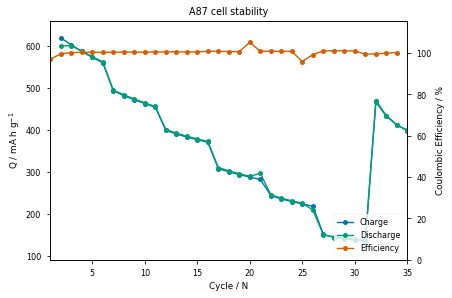

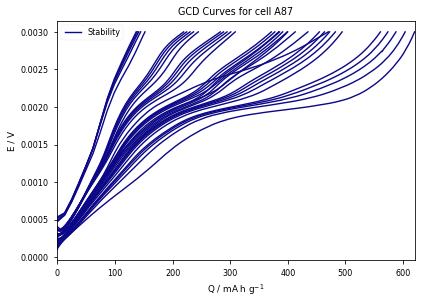

In [107]:
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt

def plot_cycle(file, filename, graphs):
    """Plots charge/discharge capacity and coulombic effeciency vs cycle"""
    df = pd.read_csv(file, delimiter="\t")
    df = df.rename(columns={"RCap_Chg":"Charge","RCap_DChg":"Discharge"})
    graph_title = filename.split("_")[0]+ " cell stability"
    plt.style.use(['seaborn-colorblind', 'seaborn-paper'])
    df = df.drop(df[df['Charge'] == 0].index)  ### skipping values of charge and discharge that are 0 
    df = df.drop(df[df['Discharge'] == 0].index) # due to exporting issues (may be harmful!)
    graph = df.plot(x='Cycle ID', y=['Charge', 'Discharge'], marker="o", markersize=5, title=graph_title)
    graph.set_ylim(df['Charge'].min()*0.67, df['Discharge'].max()*1.1) # setting limits so that the graph fits better
    if "full" not in filename:
        df['Efficiency'] = df['Discharge']/df['Charge']/100
    df = df.drop(df[df['Efficiency'] < 0.2].index)
    df['Efficiency'].plot(x='Cycle ID', secondary_y=True, marker='o', markersize=5)
    graph.right_ax.set_ylim(0,df['Efficiency'].max()*1.1)
    graph.right_ax.set_ylabel('Coulombic Efficiency / %')
    graph.set_xlabel("Cycle / N")
    graph.set_ylabel("Q / mA h g$""^{-1}$")
    h1, l1 = graph.get_legend_handles_labels()
    h2, l2 = graph.right_ax.get_legend_handles_labels()
    graph.legend(h1+h2, l1+l2, loc=4)
    graph.get_figure().savefig(os.path.join(pathlib.Path().absolute(),filename)+'.png', dpi=600)

def csv_to_graph(file, graphs="all"):
    """Send csv's to respective renderers depending on type of data"""
    filename, file_extension = os.path.splitext(file) 
    if file_extension == '.csv': # extract data only from csv files
        if "cycle" in filename:
            plot_cycle(file, filename, graphs)
    else:
        print("Skipping non-csv file...")

def send_files_to_plotter(path):
    """Plot each file in path"""
    if path=="":
      path = os.listdir(pathlib.Path().absolute())
    for file in path:
        csv_to_graph(file, graphs="all")

current_path_contents = os.listdir(pathlib.Path().absolute()) # get files in current folder
send_files_to_plotter(current_path_contents)

Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Plotting each 10 cycle of A87_c-rate_record_full from 0 to 100 cycles.
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...
Skipping non-csv file...


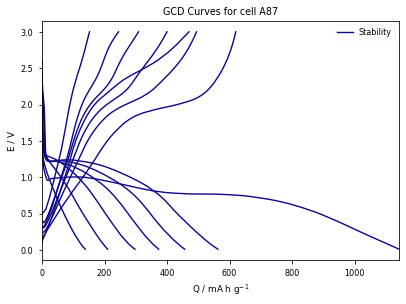

In [101]:
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt

def plot_record(file, filename, graphs, interval, start, end):
    """Plots GCD curves"""
    if interval == "":
        interval = 1
    if start == "":
        start = 0
    if end == "":
        end = 100
    print("Plotting each " + str(interval) + " cycle of " + filename + " from " + str(start) + " to " + str(end) + " cycles.")
    df = pd.read_csv(file, delimiter="\t")
    df = df.rename(columns={'Vol': 'Potential', 'Cur': 'Current', 'Cap': 'Capacity', 'CmpCap': 'Specific Capacity'})
    df_gcd = df[['Step ID', 'Current', 'Specific Capacity', 'Potential']]
    if df_gcd['Potential'].max() > 100: # just a guess that hardly anyone uses the range over 100 V but less than 100 mV, seems like a nice compromise
        df_gcd['Potential'] = df_gcd['Potential']/1000 # convert from mV to V if BTS exported mVs (it seems inconsistent)
    rest_steps = df_gcd[df_gcd['Current'] == 0].index # select rest steps
    df_gcd.drop(rest_steps, inplace=True) # drop rest steps
    steps = df_gcd['Step ID'].unique() ########  there are multiple cells with the same step like -2-2-2-...-4-4-4-...-6-6-6- (rest steps were dropped previously),
    ###########################################  thus only every second step remains, so here the steps are grouped to plot each curve separately
    plt.style.use(['seaborn-colorblind', 'seaborn-paper'])
    graph = plt.figure()
    ax = graph.gca() # getting axes so they work as intended when plotting curves
    graph_title = 'GCD Curves for cell ' + filename.split("_")[0]
    i = 0 # to reindex steps 
    for step in steps: 
        i = i + 1 # indexing steps starting with 1
        df_step = df_gcd.loc[df['Step ID'] == step]
        df_step['Step ID'] = i
        if df_step['Current'].iloc[0] > 0: # assigning type of step based on current value
            step_type = "Charge"
        elif df_step['Current'].iloc[0] < 0:
            step_type = "Discharge"
        df_step['Step Type'] = step_type
        if i == 1:                          # set the type of first step for grouping (we may start with both charge and discharge steps)
            starting_step_type = df_step['Step Type'].iloc[0]
        if df_step['Step ID'].iloc[0] >= start*2 and df_step['Step ID'].iloc[0] <= end*2: # limit what is the upper range of cycle number plotted; 
                                                                                        #doubled because each cycle contains 2 steps
            if df_step['Step Type'].iloc[0] == starting_step_type: # plotting curves of first step type
                if((df_step['Step ID'].iloc[0]-1)%interval == 0): # -1 to take into account that we start from 1, not 0
                    df_step.plot(ax=ax, x='Specific Capacity', y='Potential', colormap="plasma", title=graph_title)
            elif df_step['Step Type'].iloc[0] != starting_step_type: # plotting curves of second step type
                if((df_step['Step ID'].iloc[0]-2)%interval == 0): # -2 to take into account that the STEP belongs to the same CYCLE as previous STEP
                    df_step.plot(ax=ax, x='Specific Capacity', y='Potential', colormap="plasma", title=graph_title)
    ax.legend(['Stability'])
    ax.set_xlabel("Q / mA h g$""^{-1}$")
    ax.set_ylabel("E / V")
    ax.get_figure().savefig(os.path.join(pathlib.Path().absolute(),filename)+'.png', dpi=600)

def send_files_to_plotter(path):
    """Plot each file in path"""
    if path=="":
      path = os.listdir(pathlib.Path().absolute())
    for file in path:
        csv_to_graph(file, graphs="all")

def csv_to_graph(file, graphs="all"):
    """Send csv's to respective renderers depending on type of data"""
    filename, file_extension = os.path.splitext(file) 
    if file_extension == '.csv': # extract data only from csv files
        if "record" in filename:
            start = int(input("Enter the index of the first cycle to plot (press 'Enter' to use the default value 0)"))
            end = int(input("Enter the index of the last cycle to plot  (press 'Enter' to use the default value 100)"))
            interval = int(input("Enter the interval used for plotting cycles (press 'Enter' use the default value 1)"))
            plot_record(file, filename, graphs, interval, start, end)
    else:
        print("Skipping non-csv file...")

current_path_contents = os.listdir(pathlib.Path().absolute()) # get files in current folder
send_files_to_plotter(current_path_contents)